In [1]:
import numpy as np
import bfm
import neal
from dwave.samplers import SimulatedAnnealingSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools
import pprint

In [2]:
# Nbits (列数)
N = 16
# 反復回数
N_iter = 600
# 初期学習データ (行数)
N_initial_samples = 10

# epoch数: 2000
# 学習率: 0.01
# 1回に作られるサンプル数: 3

sampler = SimulatedAnnealingSampler()
sampler.parameters["seed"] = 0



### QUBO模型の定義

QUBOとはQuadratic Unconstrained Binary Optimizationの略で、制約条件なし0-1整数二次計画問題のことです。

QUBO模型は以下のような形のバイナリ変数の多項式関数で表されます。

$
\displaystyle H = \sum_{i<j} J_{ij} q_i q_j + \sum_i h_i q_i \quad q_i\in\{0, +1 \}
$

(FixstarsAmplify 1-tutorial-basic.jpynbより引用)

In [3]:
## オリジナルブラックボックス関数

# HOBOをブラックボックス関数として設定
# 上記に従ってコスト関数を設定

def cost_function(x, h, I, J):
    cost = 0

    # 1次の項について
    for i in range(N):
        cost += h[i] * x[i]

    # 2次の項について
    for i in range(N):
        for j in range(N):
            cost += I[i, j] * x[i] * x[j]

    # 3次の項について
    for i in range(N):
        for j in range(N):
            for k in range(N):
                cost += J[i, j, k] * x[i] * x[j] * x[k]

    return cost

In [4]:
# Create initial samples
# 初期入力データを作成する

# random.default_rng(0)ではシード値0でdefault_rngのインスタンスrngを作る
rng = np.random.default_rng(0)

# xs_realとして、N個(行) × Nビット(列)の0, 1の整数乱数配列を生成する。
# xsはN_initial_samples個(行) × Nビット(列)の0, 1の整数乱数配列とする。
xs = rng.integers(2, size=(N_initial_samples, N))
# print(f"xs_real: {xs_real}")
print(f"xs: {xs}")



# h, I, Jをランダムに作成
h = rng.uniform(-1, 1, size=N)
I = rng.uniform(-1, 1, size=(N, N))
J = rng.uniform(-1, 1, size=(N, N, N))


# I, Jそれぞれについて対称性を確保
for i in range(N):
    for j in range(i+1, N):
        I[i, j] = I [j, i]
        
for i in range(N):
    for j in range(i+1, N):
        for k in range(j+1, N):
            J[i, j, k] = J[i, k, j]
            J[i, k, j] = J[j, i, k]
            J[j, i, k] = J[j, k, i]
            J[j, k, i] = J[k, i, j]
            J[k, i, j] = J[k, j, i]
            J[k, j, i] = J[i, j, k]

## 対称性確保方法その2
# 行列h, I, Jとそれらの転置を足して√2で割る。
# I = (I + I.T)/2**0.5
# J = (J +J.T)/2**0.5

print(f"h: {h}, I: {I}, J: {J}" )

# # J, hそれぞれ1に設定
# J = np.ones((N, N))
# h = np.ones(N)

# コスト関数の返り値を求める
# itertools.product(range(a), repeat=N)とすることで、a未満の自然数で構成されるNビット列を生成できる。
ys_all =[cost_function(x, h, I, J)for x in itertools.product(range(2), repeat=N)]
ys = [(cost_function(x, h, I, J)/abs(min(ys_all))) for x in xs]
print(f"ys: {ys}")

xs: [[1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0]
 [1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0]
 [1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1]
 [0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0]
 [1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1]
 [1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0]]
h: [ 0.51545769 -0.00515461  0.05862432  0.5715714  -0.1706883   0.46896714
  0.42228576  0.86411937 -0.77013473  0.45803023  0.85484786  0.93585238
 -0.97058739  0.72728018  0.96239008  0.91442036], I: [[-7.02471976e-01  4.38439546e-01 -7.50890588e-01 -1.86979327e-01
  -2.38458983e-01  3.35778811e-01  4.68694548e-02 -5.43526828e-05
   7.37708589e-01 -6.34113351e-01  7.55057812e-01 -7.22136642e-01
   1.41369572e-01  1.38051709e-01  1.28825642e-01  5.78495097e-01]
 [ 4.38439546e-01 -9.68016541e-01 -4.23338486e-01  8.19917923e-01
  -1.40451878e-01  9.16827264e-01 -8.22128720e-01  4.88194959e-01
   2.68139959e-01  9.26038280e-01 -8.26370256

In [5]:
print(f"ys_all: {ys_all}")
print(f"min_ys_all: {min(ys_all)}")
print(f"min_ys: {min(ys)}")
print(f"len_ys: {len(ys)}")

ys_all: [0.0, 0.2315935321606648, -0.5509114453339283, 0.30413969198370383, -0.4773684929059103, 0.6949552571864193, -3.9420773786338668, 0.3163733818514207, -1.0530694908144405, -4.5874729502736145, 0.005668079929466829, -2.913428318917114, 0.7062093684324815, -2.4672122484968857, -0.318745994351455, -0.4141911454322358, 0.758207987303976, 0.10865335506748486, 0.11058073314638017, -0.4154345161169417, -2.4114686478626806, -2.2367560964868374, -6.483817386899574, -3.722896047314571, 0.9368590975606199, -1.7275025908118726, 2.602801959535367, 0.05382910959166898, -0.4059581454787202, -2.8258010256407387, -1.3346322615170856, -1.176416898014316, 1.6309871360917954, 3.5384652292315497, 3.342587373211419, 7.16344641704991, 0.36305826437561306, 4.266701577352467, -0.14824411008045546, 8.131449558831127, 3.5260727181736042, 0.9953785745353858, 5.431878765582675, 4.806415028098815, 6.8734956669979255, 5.759218367794947, 7.386503609697489, 10.640126121884864, 3.0738487853359633, 4.096437386735

In [6]:
## FMA

dataset = bfm.Dataset("all")
for x, l in zip(xs, ys):
    dataset.add(x.astype(int), l)

# Construct FM
# ビット数N, ハイパーパラメータK=8, seed=2でFM構築
model = bfm.FactorizationMachine(N, 8, seed = 0)
# Construct optimizer
optimizer = bfm.Optimizer("Adam")
# loss(学習誤差)を格納するリストを作成
list_loss =[]
# 2000回のepochを行うFMをN_iter回まわす
for _ in range(N_iter):
    # Training
    # model.trainメソッドで2000回, 学習率0.01で学習
    # lossの中には訓練の中で得られる学習誤差が出力される
    loss = model.train(optimizer, dataset, epoch=2000, learning_rate=1.0e-2)
    list_loss.append(loss)
    # Get likely solutions
    qubo, _ , _ = model.to_coefficients()
    # 1回に3個のサンプルを生成する
    res = sampler.sample_qubo(qubo, num_reads=1)
    # Add the likely solutions to training dataset
    #res.record["sample"]に解が含まれており、解を2の補数表現に直して新しい解と2の補数表現をデータセットへ追加
    for x in res.record["sample"]:
        l = cost_function(x, h, I, J)/abs(min(ys_all))
        #モデルに初期サンプルをアペンドするので、合計のサンプル数はN_iter×(1回に3個のサンプルを生成)+ N_initial_samplesとなる
        # datasetはset(集合型)で、重複を許さないから計算量を少なくできる。
        dataset.add(x.astype(int), l)
        # ysにlをアペンド
        ys.append(l)

In [7]:
print(len(list_loss))

600


In [8]:
print(f"ys: {ys}")
print(f"min_ys: {min(ys)}")
print(f"ys[-1]: {ys[-1]}")
print(res.record["sample"])
print(ys)
print(dataset)
print (dir(model))
print(type(xs))
# print(np.array(list_loss).shape)

ys: [-0.4432537613468422, -0.4246040881142792, 0.04220157856118999, -0.37944819420438847, 0.11693636459477559, 0.0195546646340834, -0.06059972085735911, -0.10703890852908408, -0.3089556350981229, -0.05979509293506121, -0.33420063359783325, -0.32210330008797816, -0.0945095266243687, -0.12891744549258166, 0.04876386355369654, -0.25121862353722724, -0.025213802511463282, 0.2954653720650468, 0.11298156939231316, -0.2841002075626471, 0.18859220705622584, 0.08075228902126493, -0.13803608071124032, -0.1170289584147813, -0.5344127516117738, -0.036631961878563796, 0.3294097083707402, -0.12041988341751236, -0.5179571589617139, -0.6476956897218162, 0.003795932997421571, -0.1326351738136793, -0.8646943953812884, -0.21648635967727742, 0.22583613997943353, -0.25101779935993135, -0.13715163386199944, -0.4096179654324529, -0.8166791863345306, -0.034871295049510864, 0.20903651885114877, -0.4807257852141996, -0.3381994044385829, -0.7116243425104841, -0.8646943953812884, -0.3325801744078492, -0.330119324

In [9]:
model.predict(list(xs[0]))

[-0.44371360540390015]

In [10]:
# dataset.to_labels()で出力ysが得られる
# dataset.to_inputs()で入力xsが得られる。

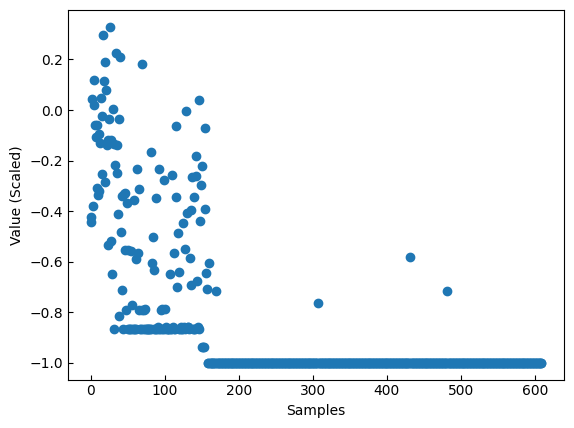

In [11]:
# サンプル数に対するValue値
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(ys, 'o')
plt.xlabel('Samples')
plt.ylabel('Value (Scaled)')
# plt.ylim([-1.0,1.0])
plt.show()

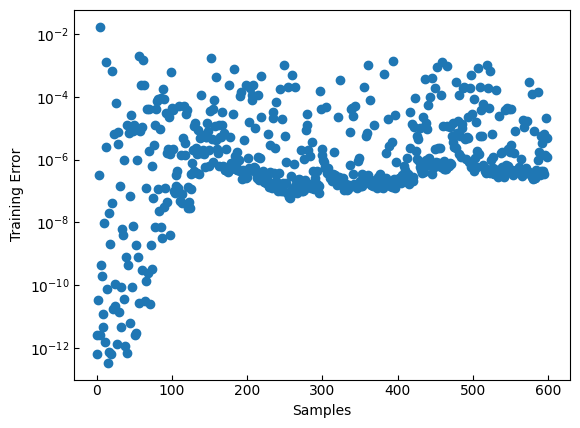

In [12]:
# サンプル数に対する学習誤差
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.yscale("log")
plt.plot(list_loss, 'o')
plt.xlabel('Samples')
plt.ylabel('Training Error')
plt.show()

In [13]:
print(dataset)

In [14]:
# 得られた全てのysのリスト
print(dataset.to_labels())
# 得られた全てのysに対するxsのリスト。ただし1ビットずつ区切られているため、得られたサンプル数が得られる
print(dataset.to_inputs())

[-0.6345229148864746, 0.11298157274723053, -0.23132015764713287, 0.08075229078531265, -0.09450952708721161, -0.4081609547138214, -0.06059972196817398, -0.5851352214813232, -0.344466894865036, -0.03487129509449005, -0.2609289288520813, 0.32940971851348877, -0.25101780891418457, -0.05979509279131889, -0.4880724549293518, -0.25121861696243286, -0.5524241924285889, -0.5029473900794983, -0.3480219841003418, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 

In [15]:
# datasetは辞書型になっていて、キーが1, 1, 0, 0, 0, 1, ...の16ビットのinputs, それに対応する値が格納されている。これが610個(サンプル数個)あるのでshapeは[610, 16]
# ただし、datasetはRust言語で書かれているため、そのまま取り出すことができないことから、dataset.to_inputsとするとキーが1次元で全て表示されてしまう仕様になっている。
print(dataset.shape())
# reshapeするためにnumpyに変換している
numpy_dataset_inputs = np.array(dataset.to_inputs()).reshape(dataset.shape())
# # 16ビットの入力がサンプル数個あるnumpyとするためにreshapeを実行
# numpy_dataset_inputs_new = numpy_dataset_inputs.reshape(dataset.shape())

[610, 16]


In [16]:
list_dataset_inputs = list(numpy_dataset_inputs)

In [17]:
print(list_dataset_inputs)

[array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]), array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]), array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]), array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]), array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]), array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]), array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]), array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]), array([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]), array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]), array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]), array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]), array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]), array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]), array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 0, 1, 0, 1, 0,

In [18]:
error = []
for idx, y in enumerate(ys):
    error.append(abs((cost_function(numpy_dataset_inputs[idx], J, h)) /abs(min(ys_all)) -y))

TypeError: cost_function() missing 1 required positional argument: 'J'

In [ ]:
print(error)